# PN Junction Iterative FEM Simulation

This notebook gives an overview of the physics that govern PN junctions and offers simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Mesh Generation

In [4]:
# Define mesh size
num_edges = 11
num_nodes = num_edges + 1
L = 0.1 # cm
dL = (2 * L) / num_edges

# Array of mesh nodes
nodes = np.linspace(0, 2 * L, num_nodes)

# Array of mesh edges
edges = np.linspace(0, num_edges, num_nodes, dtype=int).repeat(2, axis=0)[1:-1].reshape((-1,2))

# Mean x values of edges
x_avg = np.mean(nodes[edges], axis=1)

[-1000000. -1000000. -1000000. -1000000. -1000000.  1000000.  1000000.
  1000000.  1000000.  1000000.  1000000.]


# Control Inputs

In [47]:
V = 0 # V, applied voltage

# Constants

These constants are for silicon at 300K.\
References: 
- https://www.ioffe.ru/SVA/NSM/Semicond/Si/electric.html
- https://aip.scitation.org/doi/10.1063/1.1529297#:~:text=The%20commonly%20used%20value%20of,%C3%971010%20cm%E2%88%923.

In [2]:
n_i = 1e10 # cm^-3, intrinsic carrier concentration
phi_t = 21.25 # qV/(kT), S.R.H. recombination trap energy level (0.55 eV) in units of the thermal voltage
T = 300 # K, air temperature
eps_0 = 8.85e-12 # F/m, vaccuum permittivity
eps = 11.68 # silicon relative permittivity
k_B = 1.38e-23 # m^2*kg/(s^2*K), Boltzmann constant
q = 1.6e-19 # C, electron charge

# n-type
N_D = 1e6 # n_i, donor concentration 
N_CD = 1.1e6 # n_i, donor corner doping concentration
mu_0n = 1400 # cm^2/(V*s), maximum electron mobility
D_0n = 105 # cm^2/s, reference electron diffusion coefficient
v_scat_n = 1e7 # cm/s, scatter limited drift velocity of electrons
tau_n = 7e-5 # s, excess electron lifetime
A_n = 1305 # cm^2/(V*s), factor of maximum electron mobility reduction

# p-type
N_A = 1e6 # n_i, acceptor concentration
N_CA = 1.1e5 # n_i, acceptor corner doping concentration
mu_0p = 450 # cm^2/(V*s), maximum hole mobility
D_0p = 60 # cm^2/s, reference hole diffusion coefficient
v_scat_p = 7e6 # cm/s, scatter limited drift velocity of holes
tau_p = 7e-5 # s, excess hole lifetime
A_p = 420 # cm^2/(V*s), factor of maximum hole mobility reduction

# Convenience Functions

In [49]:
'''
@brief: Get the ionized impurity concentration for the mesh
@param: mesh The mesh containing positional node values
@return: np.array The array of doping conentrations
'''
def Nf(mesh):
    
    N_vector_func = np.vectorize(lambda x: -N_A if (x < L) else N_D)
    
    return N_vector_func(mesh)

# Define Boundary Conditions

### Quasi-Fermi Potentials

$\phi_p(0) = \phi_n(0) = \frac{qV}{kT}$ \
$\phi_p(L) = \phi_n(L) = 0$

In [50]:
phi_p_L = phi_n_L = V # HQFP and EQFP in units of qV/kT
phi_p_R = phi_n_R = 0

### Electric Potential

$\psi(0) = \phi_p(0) - \ln{\left(\sqrt{\left(\frac{N(0)}{2}\right)^2 + 1} - \frac{N(0)}{2}\right)}$ \
$\psi(L) = \phi_p(L) - \ln{\left(\sqrt{\left(\frac{N(L)}{2}\right)^2 + 1} - \frac{N(L)}{2}\right)}$

In [51]:
psi_L = phi_p_L - np.log(np.sqrt((Nf(0)/2)**2 + 1) - Nf(0)/2)
psi_R = phi_p_R - np.log(np.sqrt((Nf(L)/2)**2 + 1) - Nf(L)/2)

# Initialize Potentials

## Electric Potential

Make a guess at the electric potential based on the boundary conditions. A linear approximation should be a reasonable guess

$\psi(x) = \frac{\psi(L) - \psi(0)}{2L}x + \psi(0)$

In [52]:
psi = (psi_R - psi_L)/(2*L)*nodes + psi_L

## Quasi-Fermi Potentials

Set both vectors to all zero, and initialize them to the same length as the electric potential vector.

In [53]:
phi_p = phi_n = np.zeros(psi.shape)

# Define Equations

## General Equations

Equations for quantities that are not specific to holes or electrons, and are re-used often in other equations.

### Debye length

Maximum distance an ion and an electron can be separated in silicon.

$L_D = \sqrt{\frac{kT\epsilon}{q^2n_i}}$

In [67]:
L_D = np.sqrt(k_B*T*eps*eps_0/(q**2*n_i*100**3)) * 1e2 # Convert n_i to m^-3, L_D to cm

### Recombination rate

Rate at which minority charge carriers recombine to eliminate space charges.

$u(x) = n_i\frac{e^{\phi_p(x) - \phi_n(x)}}{\tau_p\left(e^{\psi(x)-\phi_n(x)} + e^{\phi_t}\right) + \tau_n\left(e^{\phi_p(x) - \psi(x)} + e^{-\phi_t}\right)}$

In [55]:
'''
@brief: Calculate the recombination rate throughout the mesh
@return: np.array An array of recombination rate values in s^-1
'''
def u():
    num = n_i * np.exp(phi_p - phi_n)
    den = tau_p * (np.exp(psi - phi_n) + np.exp(phi_t)) + tau_n * (np.exp(phi_p - psi) + np.exp(-phi_t))
    
    return num / den

### Recombination current

Current generated by recombination of minority charge carriers in the field free regions

$J_r(x) = \int \limits_0^x {L_D^2\frac{u(t)}{D_0n_i}dt}$

In [56]:
'''
@brief: Calculate the recombination current throughout the mesh
@param: mesh The mesh containing positional node values
@return: np.array An array of recombination current values expressed in the unit current
@details: The function fails if the mesh has size less than 2 to avoid inaccurate integration
'''
def J_r(mesh):
    if mesh.size < 2:
        return
    
    indices = np.linspace(0, mesh.size - 1, mesh.size, dtype=int)
    integrand = L_D**2 * u() / (D_0n * n_i) # Use larger reference diffusivity
    
    J_r_vec = np.vectorize(lambda i : np.trapz(integrand[:i], mesh[:i], mesh[1] - mesh[0]))
    
    return J_r_vec(indices)

### Electric field

The electric field is the negative spatial gradient of the electric potential.

$E(x) = -\frac{d\psi}{dx}$

In [57]:
'''
@brief: Calculate the electric field throughout the mesh
@param: mesh The mesh containing positional node values
@return: np.array An array of electric field values in V/cm
@details: The function fails if the mesh has size less than 2 to avoid undefined gradients
'''
def E(mesh):
    if mesh.size < 2:
        return
    
    dx = mesh[1] - mesh[0]
    return np.gradient(-psi, dx)

### Relative reciprocal diffusivity

The general formula is: 

$\gamma = \sqrt{1.0 + \frac{N}{N_C + \frac{N}{A^2}}} + \frac{E\mu_0}{v_{scat}}$ 

Which can be specified for holes and electrons separately.

In [58]:
'''
@brief: Get the relative reciprocal diffusivity for holes throughout the mesh
@param: mesh The mesh containing positional node values
@return: np.array The array of relative reciprocal diffusivity values for holes
'''
def gamma_p(mesh):
    return np.sqrt(1.0 + N_A / (N_CA + N_A / A_p**2)) + np.array(E(mesh)) * mu_0p / v_scat_p

'''
@brief: Get the relative reciprocal diffusivity for electrons throughout the mesh
@param: mesh The mesh containing the positional node values
@return: np.array The array of relative reciprocal diffusivity values for electrons
'''
def gamma_n(mesh):
    return np.sqrt(1.0 + N_D / (N_CD + N_D / A_n**2)) + np.array(E(mesh)) * mu_0n / v_scat_n

## Hole Equations

### Hole quasi-Fermi potential

$\phi_p(x) = \log{\left[J_{pconst}F_p(x) + e^{\phi_p(L)}\right]}$, (neglecting recombination) \
$\phi_p(x) = \log{\left[J_{pconst}F_p(x) - FR_p(x) + e^{\phi_p(L)}\right]}$, (including recombination) \
\
$J_{pconst} = \frac{e^{\phi_p(0)} - e^{\phi_p(L)}}{F_p(0)}$, constant part of electron current density (neglecting recombination) \
$J_{pconst} = \frac{e^{\phi_p(0)} - e^{\phi_p(L)} + FR_p(0)}{F_p(0)}$, constant part of electron current density (including recombination) \
$F_p(x) = \int \limits_x^L {\gamma_p(t)e^{\psi(t)}dt}$ \
$FR_p(x) = \int \limits_x^L {J_r(t)\gamma_p(t)e^{\psi(t)}dt}$ 

In [59]:
'''
@brief: Calculate the value of the hole quasi-fermi potential throughout the mesh
@param: mesh The mesh containing positional node values
@param: recomb If True, the effects of recombination will be considered
@return: np.array The array of hole quasi-fermi potential values
'''
def phi_pf(mesh, recomb):
    if mesh.size < 2:
        return
    
    indices = np.linspace(0, mesh.size - 1, mesh.size, dtype=int)
    dx = mesh[1] - mesh[0]
    
    # Calculate defined functions F and FR
    gamma = gamma_p(mesh)
    psi_exp = np.exp(psi)
    F_integrand = gamma * psi_exp
    F_func = np.vectorize(lambda i: np.trapz(F_integrand[i:], mesh[i:], dx))
    F = F_func(indices)
    
    FR = np.zeros(F.shape)
    if recomb:
        FR_integrand = J_r(mesh) * gamma * psi_exp
        FR_func = np.vectorize(lambda i: np.trapz(FR_integrand[i:], mesh[i:], dx))
        FR = FR_func(indices)
        
    # Calculate constant part of hole current density
    J_p_const = (np.exp(phi_p_L) - np.exp(phi_p_R) + FR[0]) / F[0]
    
    # Calculate phi_p
    ret = np.log(J_p_const * F + FR + np.exp(phi_p_R))
    
    # Normalize
    ret[0] = phi_p_L; ret[-1] = phi_p_R
    
    return ret

### Hole concentration

$p(x) = e^{\phi_p(x) - \psi(x)}$

In [60]:
'''
@brief: Calculate the value of the hole concentration throughout the mesh
@return: np.array The array of hole concentration values
'''
def pf():
    return np.exp(phi_p - psi)



## Electron Equations

### Electron quasi-Fermi potential

$\phi_n(x) = \log{\left[-J_{nconst}F_n(x) + e^{-\phi_n(L)}\right]}$, (neglecting recombination) \
$\phi_n(x) = \log{\left[-J_{nconst}F_n(x) - FR_n(x) + e^{-\phi_n(L)}\right]}$, (including recombination) \
\
$J_{nconst} = \frac{e^{-\phi_n(L)} - e^{-\phi_n(0)}}{F_n(0)}$, constant part of hole current density (neglecting recombination) \
$J_{nconst} = \frac{e^{-\phi_n(L)} - e^{-\phi_n(0)} - FR_n(0)}{F_n(0)}$, constant part of hole current density (including recombination) \
$F_n(x) = \int \limits_x^L {\gamma_n(t)e^{-\psi(t)}dt}$ \
$FR_n(x) = \int \limits_x^L {J_r(t)\gamma_n(t)e^{-\psi(t)}dt}$ 

In [61]:
'''
@brief: Calculate the value of the electron quasi-Fermi potential throughout the mesh
@param: mesh The mesh containing positional node values
@param: recomb If True, the effects of recombination will be considered
@return: np.array The array of electron quasi-Fermi potential values
'''
def phi_nf(mesh, recomb):
    if mesh.size < 2:
        return
    
    indices = np.linspace(0, mesh.size - 1, mesh.size, dtype=int)
    dx = mesh[1] - mesh[0]
    
    # Calculate defined functions F and FR
    gamma = gamma_n(mesh)
    psi_exp = np.exp(-psi)
    F_integrand = gamma * psi_exp
    F_func = np.vectorize(lambda i: np.trapz(F_integrand[i:], mesh[i:], dx))
    F = F_func(indices)
    
    FR = np.zeros(F.shape)
    if recomb:
        FR_integrand = J_r(mesh) * gamma * psi_exp
        FR_func = np.vectorize(lambda i: np.trapz(FR_integrand[i:], mesh[i:], dx))
        FR = FR_func(indices)
        
    # Calculate constant part of electron current density
    J_n_const = (np.exp(-phi_n_L) - np.exp(-phi_n_R) - FR[0]) / F[0]
    
    # Calculate phi_n
    ret = np.log(-J_n_const * F - FR + np.exp(-phi_n_R))
    
    # Normalize
    ret[0] = phi_n_L; ret[-1] = phi_n_R
    
    return ret

### Electron concentration

$n(x) = e^{\psi(x) - \phi_n(x)}$

In [62]:
'''
@brief: Calculate the value of the electron concentration throughout the mesh
@return: np.array The array of electron concentration values
'''
def nf():
    return np.exp(psi - phi_n)

# Gummel Iteration

## Compute initial quantities neglecting recombination

Initially we do not have a guess for the EQFP or HQFP, which the recombination current density $J_r$ depends on.

In [63]:
N = Nf(x_avg)

phi_n = phi_nf(nodes, recomb=False)
phi_p = phi_pf(nodes, recomb=False)

n = nf()
p = pf()

## Define functions to compute matrix elements

In [64]:
'''
@brief Compute block of NxN matrix A
@return np.array matrix of values
'''
def dNi_dNj():
    a = np.zeros((2,2))
    a[0] = 1 / dL * np.array([1,-1])
    a[1] = 1 / dL * np.array([-1,1])
    
    return a

'''
@brief Compute segment of Nx1 array b
@return np.array array of values
'''
def Ni():
    return dL / 2 * np.array([1,1])

## Define iteration function

In [65]:
'''
@brief: Iteration step, will compute new values for psi throughout the mesh
@param: mesh The mesh edges to operate on
@param: alpha psi = (1-alpha)*psi + alpha*psi_new, where alpha < 1
@return: np.array The array of potential values
'''
def iterate(mesh, alpha):
    
    A = np.zeros((num_nodes, num_nodes))
    b = np.zeros((num_nodes, 1))
    
    for i in range(0, num_edges):
        nds = mesh[i]
        
        a = dNi_dNj() * np.trapz(N[i] + p[nds] - n[nds], dx=dL)
        b0 = Ni()
        
        A[np.ix_(nds, nds)] += a
        b[nds] += b0.reshape((2,1))
    
    # Enforce boundary conditions
    A[0][0] = 1; A[0][1:] = 0
    A[-1][-1] = 1; A[-1][:-1] = 0
    
    b[0] = psi_L; b[-1] = psi_R
    
    psi_new = np.linalg.solve(A, b).reshape(psi.shape)
    
    return (1 - alpha) * psi + alpha * psi_new

# Iterate

The iteration should run until the solution converges. Convergence is defined by an update threshold which is given by the mean error between points in the potential vector.

KeyboardInterrupt: 

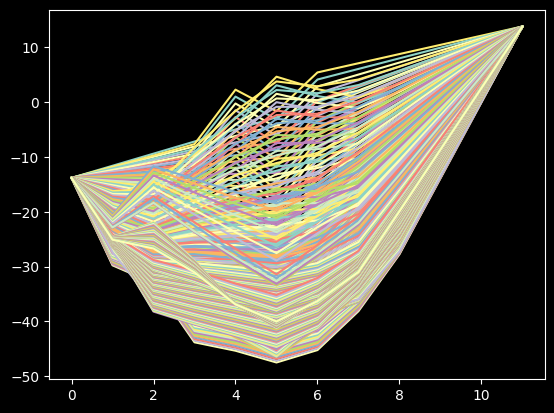

In [66]:
thresh = 1e-2
alpha = 0.01
mean_error = 1

while (mean_error > thresh):
    
    # Calculate new value for psi
    psi_update = iterate(edges, alpha)
    
    # Update the mean error
    mean_error = np.mean(np.abs(psi - psi_update))
    
    # Update psi
    psi = psi_update
    
    # Recalculate the EQFP and HQFP accounting for recombination
    phi_n = phi_nf(nodes, recomb=True)
    phi_p = phi_pf(nodes, recomb=True)
    
    # Recalculate the hole and electron concentrations
    p = pf()
    n = nf()

    plt.plot(psi)

In [47]:
psi

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])